In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from vae_utils import plot_sweeps_mnist_vae, generate_data, standard_vae, contrastive_vae, plot_latent_space, plot_latent_space4d, contrastive_vae_no_bias, plot_clean_digits, plot_clean_digits_only, plot_sweeps_mnist, plot_clean_digits_vae
from sklearn.metrics import silhouette_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load the Dataset

In [2]:
np.random.seed(0)
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

target_idx = np.where(y_train<3)[0]
foreground = x_train[target_idx,:][:10000].reshape(-1, 784)/256
target_labels = y_train[target_idx][:10000]

In [3]:
from PIL import Image
from utils import resize_and_crop
import os

IMAGE_PATH = '/home/a12d/home/a12d/Imagenet-Grass' #Replace with your own path to downloaded images
        
natural_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
for filename in os.listdir(IMAGE_PATH):
    if filename.endswith(".JPEG") or filename.endswith(".JPG") or filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(IMAGE_PATH,filename))
            im = im.convert(mode="L") #convert to grayscale
            im = resize_and_crop(im) #resize and crop each picture to be 100px by 100px
            natural_images.append(np.reshape(im, [10000])) 
        except Exception as e:
            pass #print(e)
            
natural_images=np.asarray(natural_images,dtype=float)
natural_images/=255 #rescale to be 0-1
print("Array of grass images:",natural_images.shape)

Array of grass images: (895, 10000)


In [8]:
np.random.seed(0) # for reproducibility

rand_indices =  np.random.permutation(natural_images.shape[0]) # just shuffles the indices
split = int(len(rand_indices)/2)
target_indices = rand_indices[0:split] # choose the first half of images to be superimposed on target
background_indices = rand_indices[split:] # choose the second half of images to be background dataset

target = np.zeros(foreground.shape)
background = np.zeros(foreground.shape)

for i in range(target.shape[0]):
    idx = np.random.choice(target_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    target[i] = 0.5*foreground[i] + superimposed_patch
    
    idx = np.random.choice(background_indices) # randomly pick a image 
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
    background[i] = background_patch

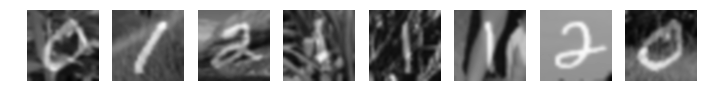

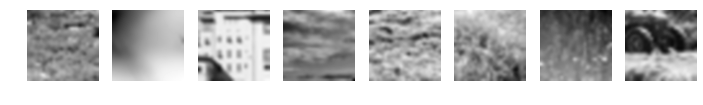

In [9]:
n_show=8

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(5000)
    plt.imshow(np.reshape(target[i,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(5000)
    plt.imshow(np.reshape(background[i,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')

# VAE

In [21]:
vae, encoder, decoder = standard_vae(input_dim=784, intermediate_dim=32, 
                                     latent_dim=2)

Text(0.5, 1.0, 'Min loss:117.78285158691406')

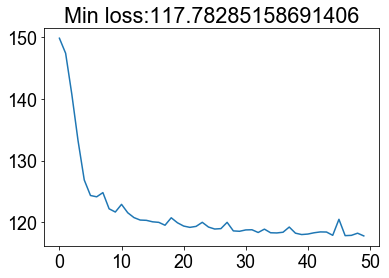

In [22]:
history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
plt.plot(history.history['val_loss'])
min_loss = min(history.history['val_loss'])
plt.title('Min loss:' + str(min_loss))

-0.018

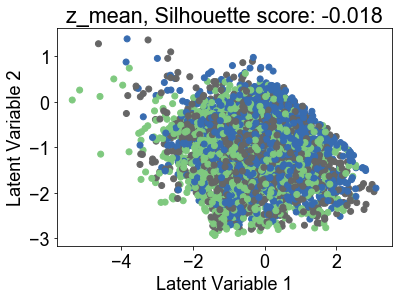

In [23]:
plot_latent_space(encoder, target, target_labels)

# VAE 4D

In [13]:
vae, encoder, decoder = standard_vae(input_dim=784, intermediate_dim=32, 
                                     latent_dim=4)

Text(0.5,1,'Min loss:30.0081566833')

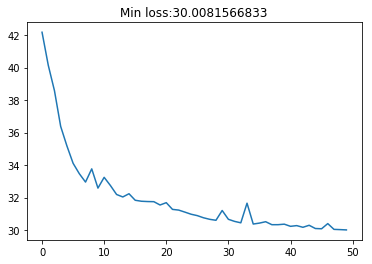

In [14]:
history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
plt.plot(history.history['val_loss'])
min_loss = min(history.history['val_loss'])
plt.title('Min loss:' + str(min_loss))

0.124

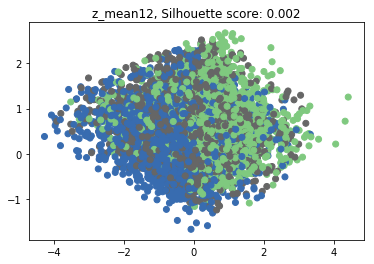

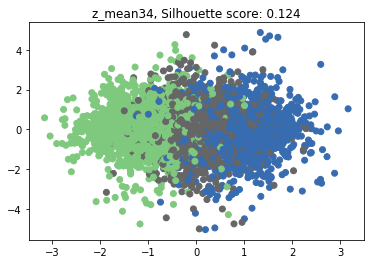

In [17]:
plot_latent_space4d(encoder, target, target_labels)

# Numerical Analysis

In [13]:
def analyze(target, background, scale=1.5):
    for i in range(target.shape[0]):
        idx = np.random.choice(target_indices) # randomly pick a image 
        loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
        superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
        target[i] = foreground[i] + scale*superimposed_patch

        idx = np.random.choice(background_indices) # randomly pick a image 
        loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
        background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
        background[i] = background_patch

    target = target / target.max()
    background = background / background.max()            

    if target.shape[0] > background.shape[0]:
        num_repeats = int(target.shape[0]/background.shape[0]) + 1
        background = np.concatenate(num_repeats*[background], axis=0)
        background = background[:target.shape[0]]
    else:
        background = background[:target.shape[0]]  

    #     mdl = CPCA(standardize=False)
    #     mdl.fit_transform(target, background, max_log_alpha=5, plot=True, active_labels=labels)
    #     projected_data = mdl.fit_transform(target, background, max_log_alpha=5, plot=False, active_labels=labels)

    vae, encoder, decoder = standard_vae(input_dim=784, intermediate_dim=32, latent_dim=2)
    history = vae.fit(target, epochs=50, batch_size=100, validation_data=(target, None), verbose=0)
    #     plt.plot(history.history['val_loss'])
    #     min_loss = min(history.history['val_loss'])
    #     plt.title('Min loss:' + str(min_loss))

    #     plt.figure()
    ss = plot_latent_space(encoder, target, target_labels, name='VAE', plot=True)

    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
        input_dim=784, intermediate_dim=128, latent_dim=2, disentangle=True, gamma=1)


    history = cvae.fit([target, background], epochs=50, batch_size=100, validation_data=([target, background], None), verbose=0)

    #     plt.figure()
    #     plt.plot(history.history['val_loss'])
    #     min_loss = min(history.history['val_loss'])
    #     plt.title('Min loss:' + str(min_loss))

    css = plot_latent_space(z_encoder, target, target_labels, name='cVAE', plot=True)
    return ss, css

0.019 0.33
-0.004 0.355
0.046 0.342
0.022 0.338
0.009 0.337
0.009 0.324
0.01 0.344
0.0 0.331
0.007 0.327
-0.012 0.419


/home/a12d/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


{'boxes': [<matplotlib.lines.Line2D at 0x7efc680b5518>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc680b5cf8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc680bf710>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efc680bf3c8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7efc680b5668>,
  <matplotlib.lines.Line2D at 0x7efc680ca128>]}

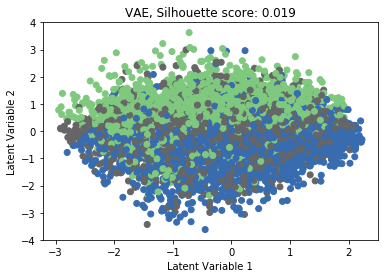

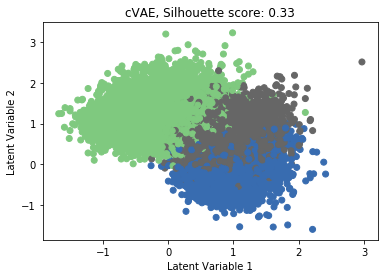

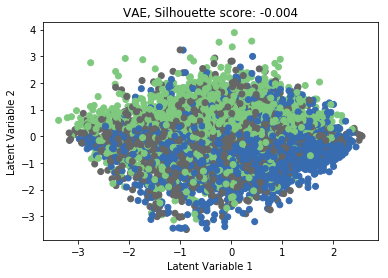

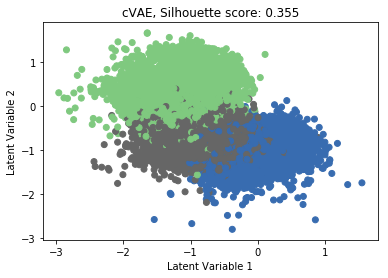

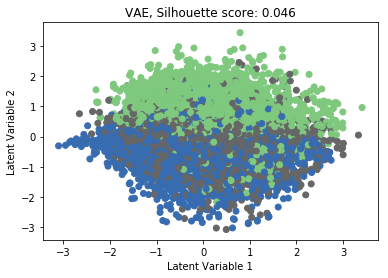

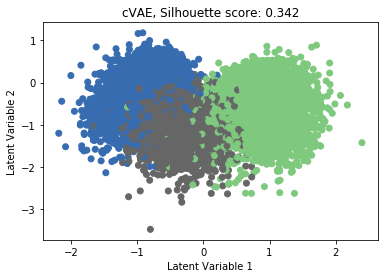

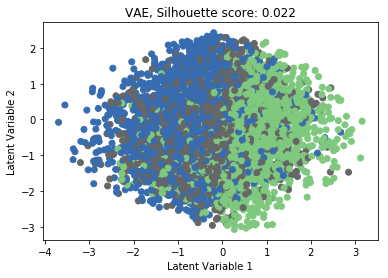

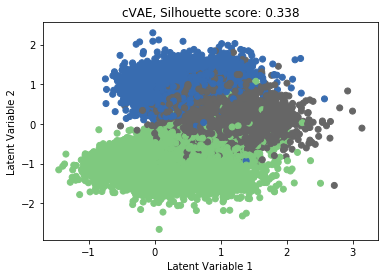

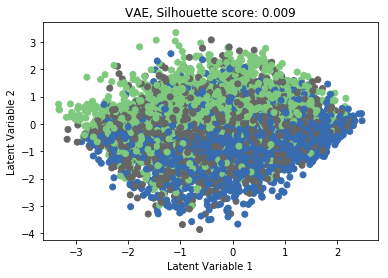

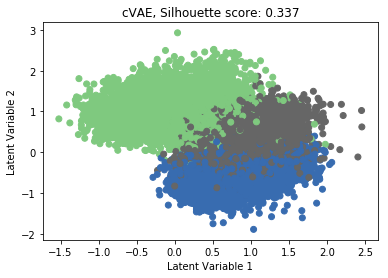

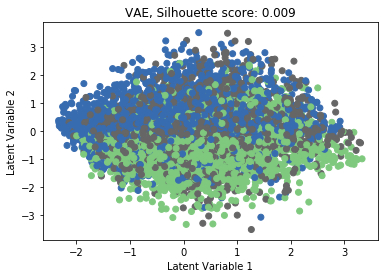

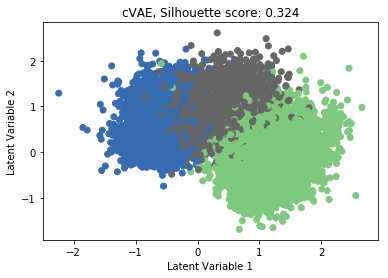

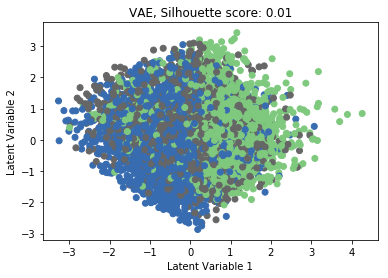

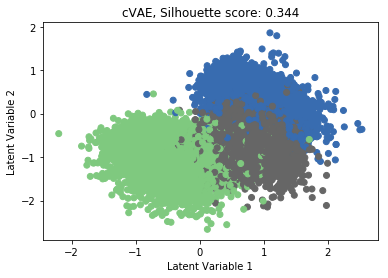

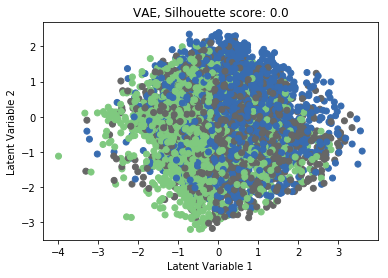

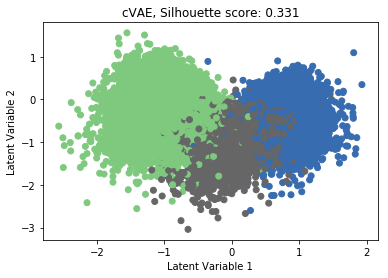

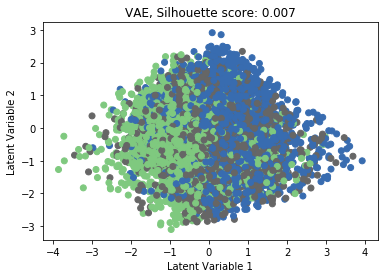

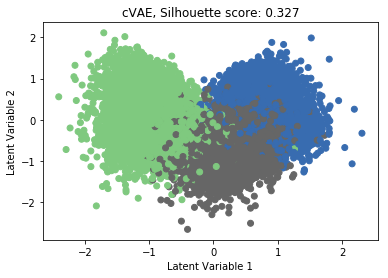

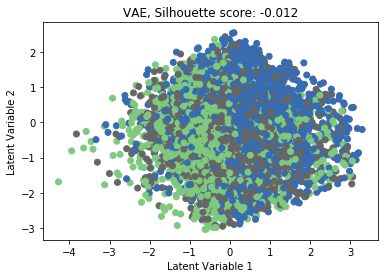

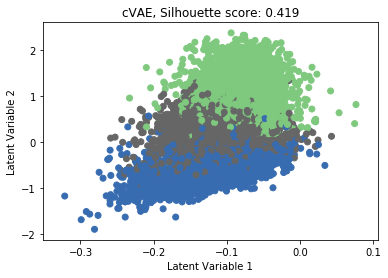

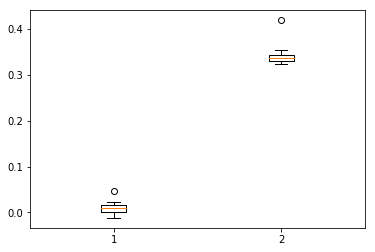

In [14]:
sss = list()
csss = list()

for i in range(10):
    ss, css = analyze(target, background, scale=1.75)
    print(ss, css)
    sss.append(ss)
    csss.append(css)

plt.figure()
plt.boxplot([sss, csss])

In [43]:
vae, encoder, decoder = standard_vae(input_dim=784, intermediate_dim=32, latent_dim=2)
history = vae.fit(target, epochs=50, batch_size=100, validation_data=(target, None), verbose=0)

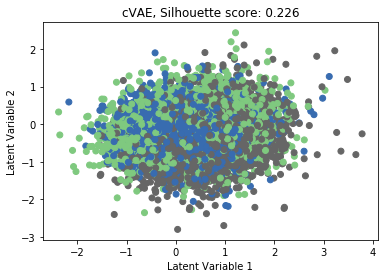

In [17]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
    input_dim=784, intermediate_dim=128, latent_dim=10, latent_dim_s=10, disentangle=True, gamma=1)


history = cvae.fit([target, background], epochs=50, batch_size=100, validation_data=([target, background], None), verbose=0)

#     plt.figure()
#     plt.plot(history.history['val_loss'])
#     min_loss = min(history.history['val_loss'])
#     plt.title('Min loss:' + str(min_loss))

css = plot_latent_space(z_encoder, target, target_labels, name='cVAE', plot=True)

Text(0, 0.5, 'Silhouette Score')

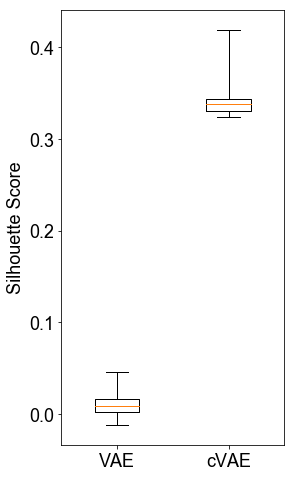

In [35]:
import matplotlib

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=[4, 8])
plt.boxplot([sss, csss], whis='range', vert=True, widths=0.4)
plt.xticks([1, 2], ['VAE', 'cVAE'])
plt.ylabel('Silhouette Score')

# cVAE (without bias)

In [18]:
cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
    input_dim=784, intermediate_dim=32, latent_dim=2)

Text(0.5,1,'Min loss:48.3786227783')

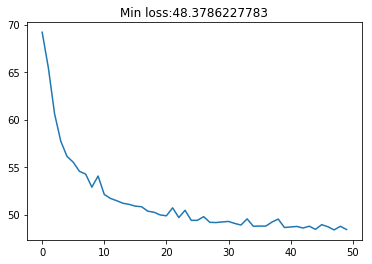

In [19]:
history = cvae.fit([target, background], epochs=50, batch_size=128, validation_data=([target, background], None), verbose=0)
plt.plot(history.history['val_loss'])
min_loss = min(history.history['val_loss'])
plt.title('Min loss:' + str(min_loss))

-0.013

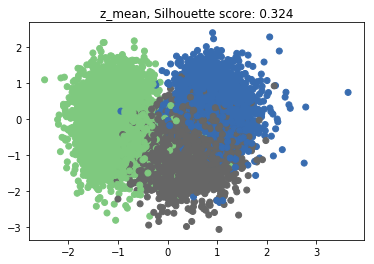

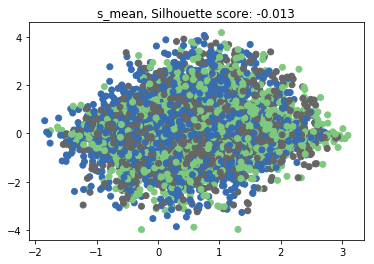

In [20]:
plot_latent_space(z_encoder, target, target_labels)
plot_latent_space(s_encoder, target, target_labels, name='s_mean')

# Cleaning

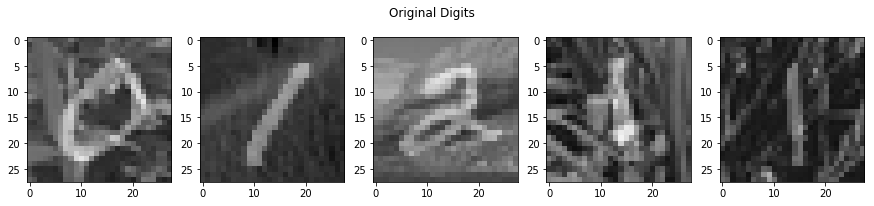

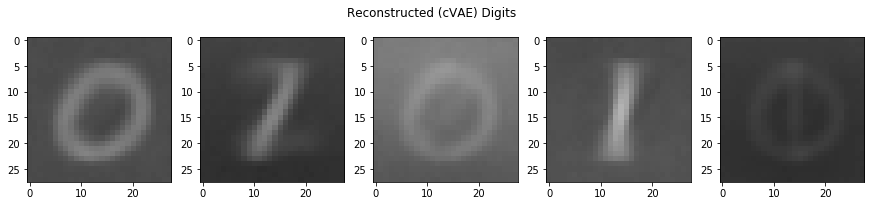

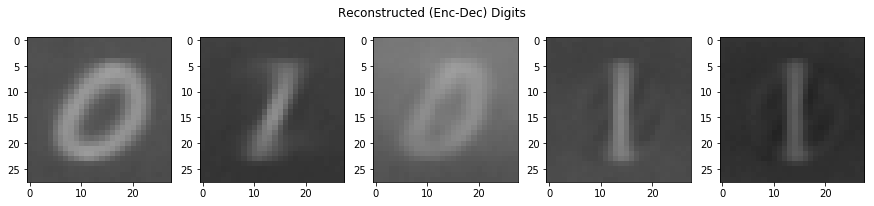

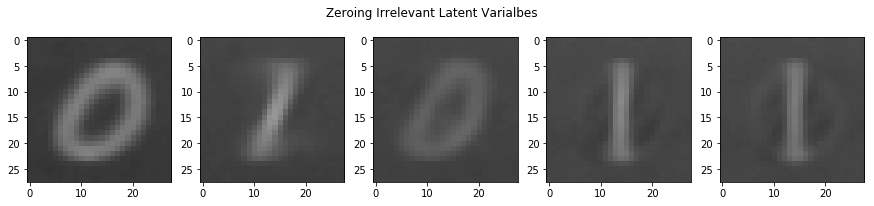

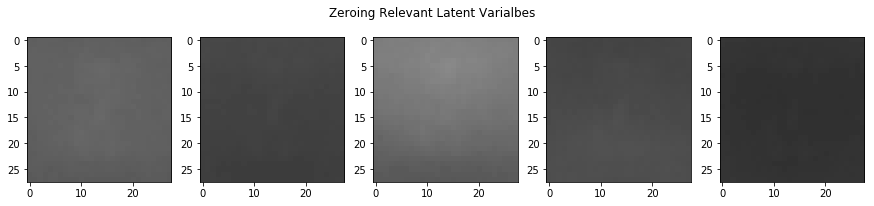

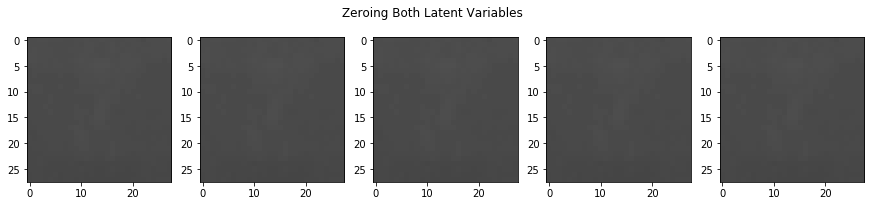

In [21]:
plot_clean_digits(cvae, z_encoder, s_encoder, cvae_decoder, target, background)

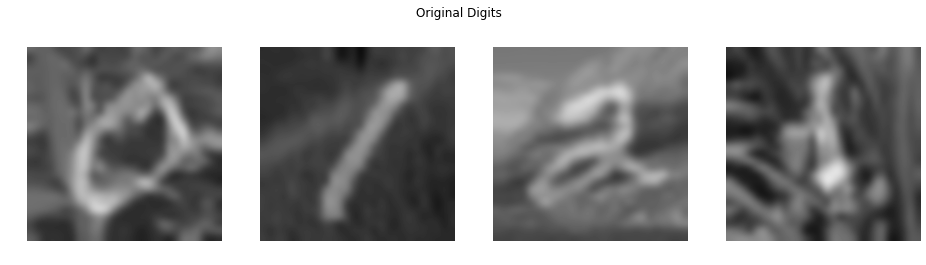

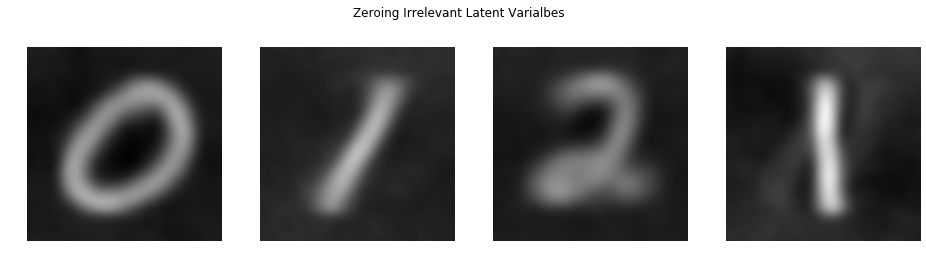

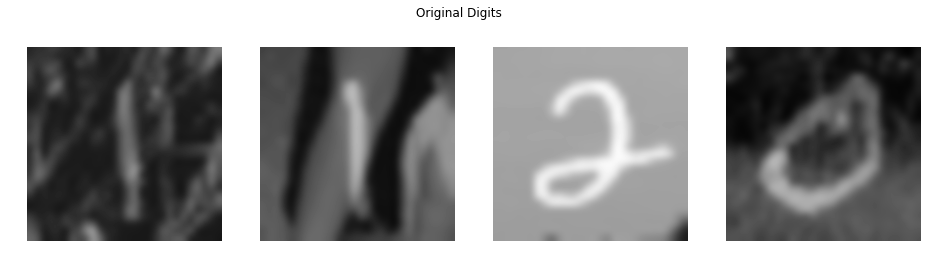

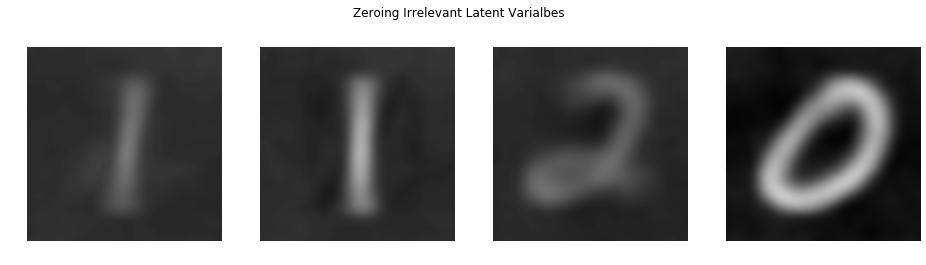

In [16]:
plot_clean_digits_only(cvae, z_encoder, s_encoder, cvae_decoder, target, background)

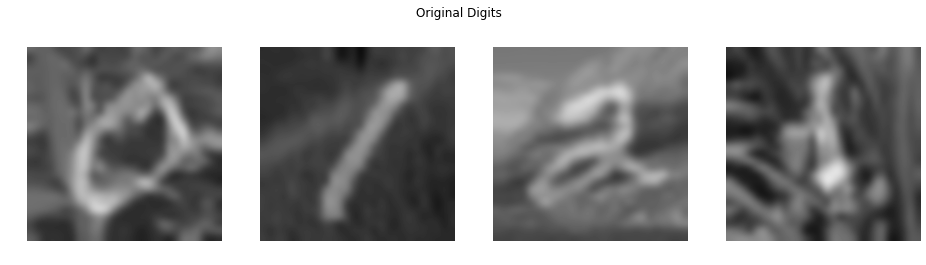

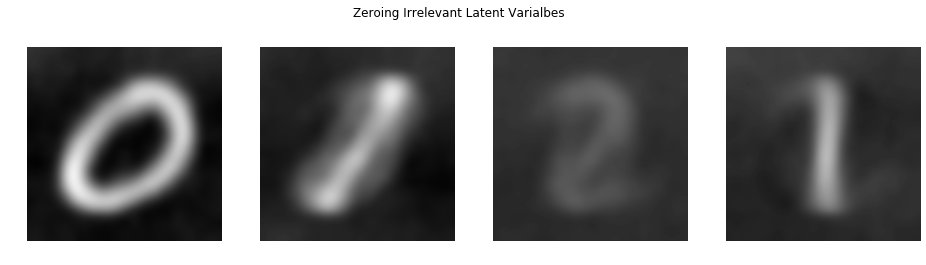

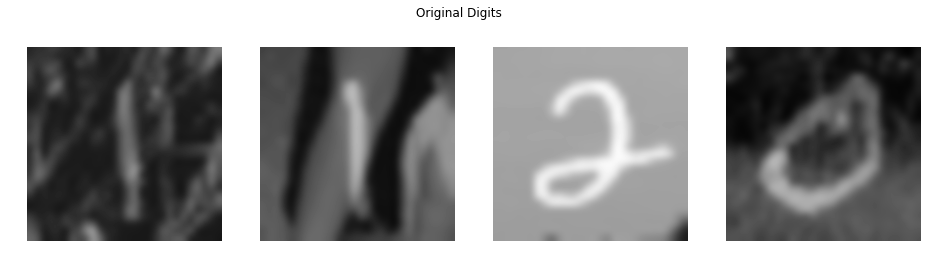

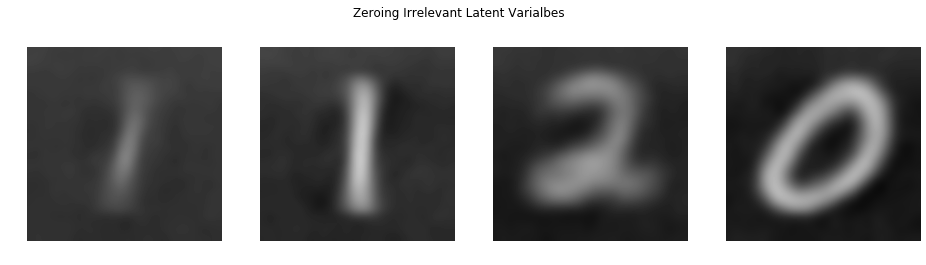

In [18]:
plot_clean_digits_only(cvae, z_encoder, s_encoder, cvae_decoder, target, background)

# Synthesizing

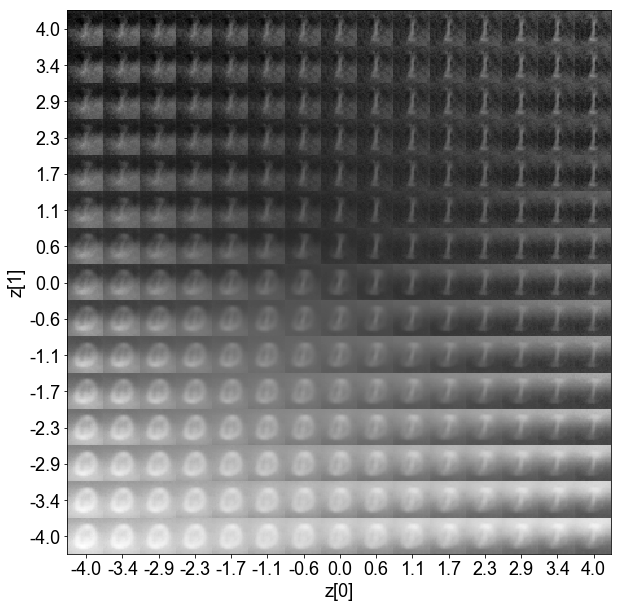

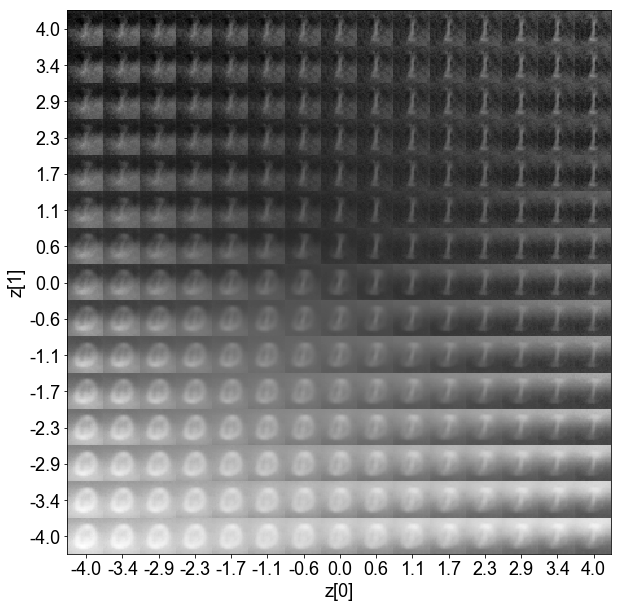

In [27]:
font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plot_sweeps_mnist_vae(decoder)

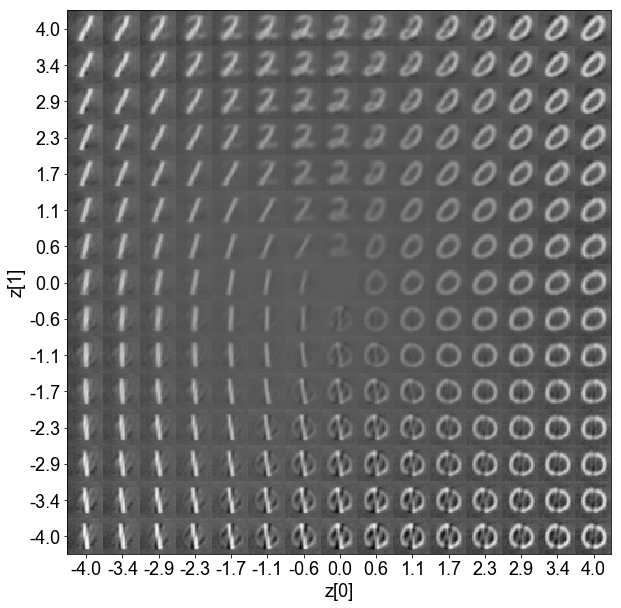

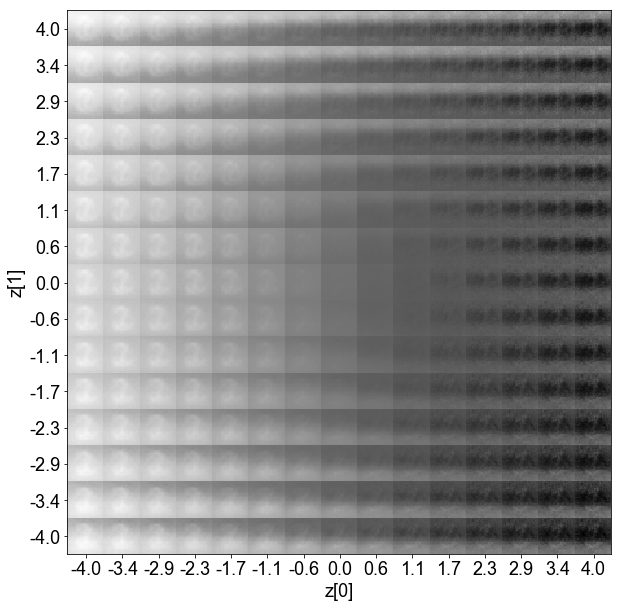

In [39]:
plot_sweeps_mnist(cvae_decoder)

# Sensitivity Analysis 2

In [58]:
import os.path

np.random.seed(0)

scales = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
iters = 5

standard_scores = np.zeros((iters, len(scales)))
contrastive_scores = np.zeros((iters, len(scales)))
b_scores = [np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales)))]
g_scores = [np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales)))]

for s, scale in enumerate(scales):
    for j in range(iters):
        print('Iteration:', j, scale)
        s_fname = 'results2/numerical-s-' + str(j) + '-' + str(s) + '-normalized.npy'
        g1_fname = 'results2/numerical-g1-' + str(j) + '-' + str(s) + '-normalized.npy'
        
        for i in range(target.shape[0]):
            idx = np.random.choice(target_indices) # randomly pick a image 
            loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
            superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
            target[i] = foreground[i] + scale*superimposed_patch

            idx = np.random.choice(background_indices) # randomly pick a image 
            loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
            background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
            background[i] = background_patch
            
        target = target / target.max()
        background = background / background.max()            
                
        if os.path.isfile(s_fname):
            temp = np.load(s_fname)
            x, y = temp.shape
            standard_scores[:x, :y] = temp 
        else:
            vae, encoder, decoder = standard_vae(input_dim=784, intermediate_dim=32, latent_dim=2)        
            history = vae.fit(target, epochs=50, batch_size=128, validation_data=(target, None), verbose=0)
            ss = plot_latent_space(encoder, target, target_labels, plot=False)
            standard_scores[j, s] = ss
            print(ss)
            np.save(s_fname, standard_scores)
        
#         if os.path.isfile(c_fname):
#             temp = np.load(c_fname)
#             x, y = temp.shape
#             contrastive_scores[:x, :y] = temp 
#         else:            
#             cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(input_dim=784, intermediate_dim=32, latent_dim=2)
#             history = cvae.fit([target, background], epochs=50, batch_size=128, validation_data=([target, background], None), verbose=0)
#             ss = plot_latent_space(z_encoder, target, target_labels, plot=False)
#             print(ss)
#             contrastive_scores[j, s] = ss
#             np.save(c_fname, contrastive_scores)        
        
#         for b, (fname, beta) in enumerate(zip([b2_fname, b5_fname, b10_fname, b25_fname], [2, 5, 10, 25])):
#             if os.path.isfile(fname):
#                 b_scores[b] = np.load(fname)
#             else:            
#                 cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(input_dim=784, intermediate_dim=32, latent_dim=2, beta=beta)
#                 history = cvae.fit([target, background], epochs=50, batch_size=128, validation_data=([target, background], None), verbose=0)
#                 ss = plot_latent_space(z_encoder, target, target_labels, plot=False)
#                 print(ss)
#                 b_scores[b][j, s] = ss
#                 np.save(fname, b_scores[b])        
                
        for b, (fname, gamma) in enumerate(zip([g1_fname], [1])):
            if os.path.isfile(fname):
                temp = np.load(fname)
                x, y = temp.shape
                g_scores[b][:x, :y] = temp
            else:            
                cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(input_dim=784, intermediate_dim=32, latent_dim=2, disentangle=True, gamma=gamma)
                history = cvae.fit([target, background], epochs=50, batch_size=100, validation_data=([target, background], None), verbose=0)
                ss = plot_latent_space(z_encoder, target, target_labels, plot=False)
                print(ss)
                g_scores[b][j, s] = ss
                np.save(fname, g_scores[b])        

Iteration: 0 0
0.439
0.443
Iteration: 1 0
0.447
0.452
Iteration: 2 0
0.44
0.43
Iteration: 3 0
0.441
0.39
Iteration: 4 0
0.452
0.311
Iteration: 0 0.5
0.39
0.387
Iteration: 1 0.5
0.383
0.361
Iteration: 2 0.5
0.413
0.339
Iteration: 3 0.5
0.391
0.359
Iteration: 4 0.5
0.374
0.456
Iteration: 0 1
0.207
0.37
Iteration: 1 1
0.224
0.375
Iteration: 2 1
0.22
0.376
Iteration: 3 1
0.214
0.373
Iteration: 4 1
0.216
0.372
Iteration: 0 1.5
0.178
0.358
Iteration: 1 1.5
0.137
0.354
Iteration: 2 1.5
0.161
0.325
Iteration: 3 1.5
0.183
0.338
Iteration: 4 1.5
0.183
0.354
Iteration: 0 2
-0.018
0.307
Iteration: 1 2
-0.019
0.318
Iteration: 2 2
-0.019
0.307
Iteration: 3 2
-0.017
0.306
Iteration: 4 2
-0.017
0.318
Iteration: 0 2.5
-0.016
0.121
Iteration: 1 2.5
-0.018
0.207
Iteration: 2 2.5
-0.016
0.169
Iteration: 3 2.5
-0.018
0.237
Iteration: 4 2.5
-0.014
0.213
Iteration: 0 3
-0.014
0.029
Iteration: 1 3
-0.013
0.021
Iteration: 2 3
-0.016
0.034
Iteration: 3 3
-0.013
-0.01
Iteration: 4 3
-0.013
0.021
Iteration: 0 3.5

In [112]:
fname = 'results2/numerical-g1-' + str(4) + '-' + str(8) + '-normalized.npy'
if os.path.isfile(fname):
    temp = np.load(fname)
    x, y = temp.shape
    c_scores = temp
    
fname = 'results2/numerical-s-' + str(4) + '-' + str(8) + '-normalized.npy'
if os.path.isfile(fname):
    temp = np.load(fname)
    x, y = temp.shape
    s_scores = temp

Text(0, 0.5, 'Silhouette Score')

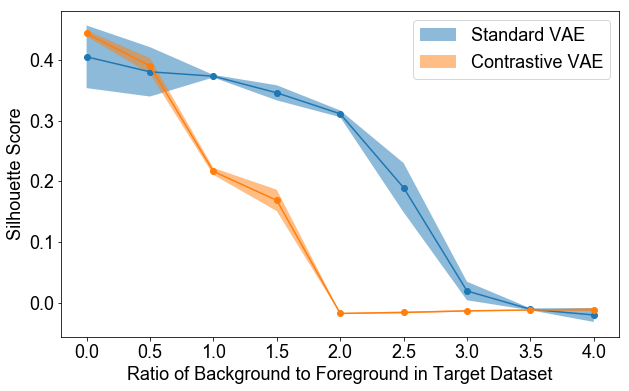

In [115]:
import matplotlib

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

scales = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]

def plt_shaded(x, y, label=None):
    plt.plot(x, y.mean(axis=0), '-o')
    plt.fill_between(x, y.mean(axis=0) - y.std(axis=0), y.mean(axis=0) + y.std(axis=0), alpha=0.5, interpolate=True, label=label)

plt.figure(figsize=[10,6])
plt_shaded(scales, c_scores, label="Standard VAE")
plt_shaded(scales, s_scores, label="Contrastive VAE")
plt.legend()
plt.xlabel('Ratio of Background to Foreground in Target Dataset')
plt.ylabel('Silhouette Score')

# Sensitivity Analysis 3

In [10]:
import os.path

np.random.seed(0)

scales = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
iters = 5

standard_scores = np.zeros((iters, len(scales)))
contrastive_scores = np.zeros((iters, len(scales)))
b_scores = [np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales)))]
g_scores = [np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales)))]

for s, scale in enumerate(scales):
    for j in range(iters):
        print('Iteration:', j, scale)
        s_fname = 'results6/numerical-s-' + str(j) + '-' + str(s) + '-normalized.npy'
        g1_fname = 'results6/numerical-g1-' + str(j) + '-' + str(s) + '-normalized.npy'
            
        target = target / target.max()
        background = background / background.max()            
                                
        for b, (fname, gamma) in enumerate(zip([g1_fname], [1])):
            if os.path.isfile(fname):
                temp = np.load(fname)
                x, y = temp.shape
                g_scores[b][:x, :y] = temp
            else:            
                cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(input_dim=784, intermediate_dim=32, latent_dim=2, disentangle=True, gamma=gamma)
                history = cvae.fit([target, background], epochs=50, batch_size=100, validation_data=([target, background], None), verbose=0)
                ss = plot_latent_space(z_encoder, target, target_labels, plot=False)
                print(ss)
                g_scores[b][j, s] = ss
                np.save(fname, g_scores[b])        
                
    for i in range(target.shape[0]):
        background[i] = background[i] + 0.25*np.random.random(background[i].shape)

Iteration: 0 0
0.337
Iteration: 1 0
0.302
Iteration: 2 0
0.317
Iteration: 3 0
0.273
Iteration: 4 0
0.33
Iteration: 0 0.25
0.308
Iteration: 1 0.25
0.285
Iteration: 2 0.25
0.287
Iteration: 3 0.25
0.316
Iteration: 4 0.25
0.303
Iteration: 0 0.5
0.313
Iteration: 1 0.5
0.257
Iteration: 2 0.5
0.291
Iteration: 3 0.5
0.285
Iteration: 4 0.5
0.319
Iteration: 0 0.75
0.278
Iteration: 1 0.75
0.12
Iteration: 2 0.75
0.183
Iteration: 3 0.75
0.153
Iteration: 4 0.75
0.272
Iteration: 0 1
0.262
Iteration: 1 1
0.187
Iteration: 2 1
0.146
Iteration: 3 1
0.104
Iteration: 4 1
0.277
Iteration: 0 1.25
0.171
Iteration: 1 1.25
0.263
Iteration: 2 1.25
0.297
Iteration: 3 1.25
0.107
Iteration: 4 1.25
0.118
Iteration: 0 1.5
0.133
Iteration: 1 1.5
0.15
Iteration: 2 1.5
0.208
Iteration: 3 1.5
0.3
Iteration: 4 1.5
0.259
Iteration: 0 1.75
0.186
Iteration: 1 1.75
0.126
Iteration: 2 1.75
0.131
Iteration: 3 1.75
0.153
Iteration: 4 1.75
0.151
Iteration: 0 2
0.029
Iteration: 1 2
0.145
Iteration: 2 2
0.193
Iteration: 3 2
0.168
I

In [11]:
fname = 'results6/numerical-g1-' + str(4) + '-' + str(8) + '-normalized.npy'
if os.path.isfile(fname):
    temp = np.load(fname)
    x, y = temp.shape
    c_scores = temp

Text(0, 0.5, 'Silhouette Score')

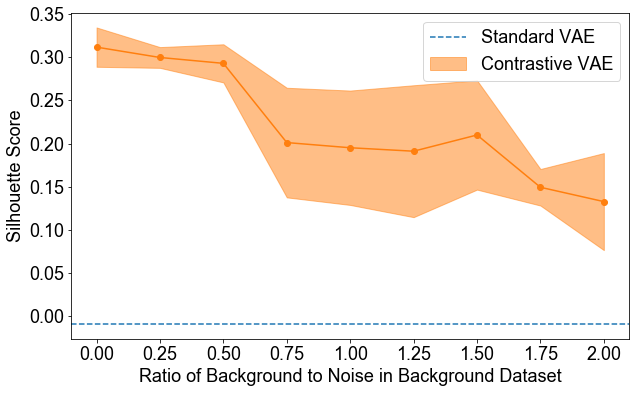

In [12]:
import matplotlib

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

scales = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
pick = [0, 1, 2, 3, 4, 5, 6, 7, 8]

def plt_shaded(x, y, label=None, c=None):
    plt.plot(x, y.mean(axis=0), '-o', c=c)
    plt.fill_between(x, y.mean(axis=0) - y.std(axis=0), y.mean(axis=0) + y.std(axis=0), alpha=0.5, interpolate=True, label=label, color=c)

plt.figure(figsize=[10,6])
plt.axhline(-0.009, ls='--', label='Standard VAE')
plt_shaded(np.array(scales)[pick], c_scores[:, pick], label="Contrastive VAE", c='C1')
plt.legend()
plt.xlabel('Ratio of Background to Noise in Background Dataset')
plt.ylabel('Silhouette Score')

Text(0, 0.5, 'Silhouette Score')

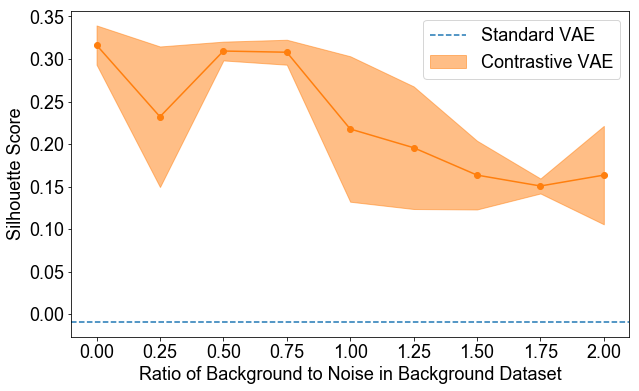

In [7]:
import matplotlib

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

scales = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]
pick = [0, 1, 2, 3, 4, 5, 6, 7, 8]

def plt_shaded(x, y, label=None, c=None):
    plt.plot(x, y.mean(axis=0), '-o', c=c)
    plt.fill_between(x, y.mean(axis=0) - y.std(axis=0), y.mean(axis=0) + y.std(axis=0), alpha=0.5, interpolate=True, label=label, color=c)

plt.figure(figsize=[10,6])
plt.axhline(-0.009, ls='--', label='Standard VAE')
plt_shaded(np.array(scales)[pick], c_scores[:, pick], label="Contrastive VAE", c='C1')
plt.legend()
plt.xlabel('Ratio of Background to Noise in Background Dataset')
plt.ylabel('Silhouette Score')

# Sensitivity Analysis 4

In [6]:
import os.path

np.random.seed(0)

scales = [1, 2, 3, 4, 5, 6]
iters = 3

g_scores = [np.zeros((iters, len(scales), len(scales)))]

for s, scale in enumerate(scales):
    for s2, scale2 in enumerate(scales):
        for j in range(iters):
            print('Iteration:', j, scale, scale2)
            g1_fname = 'results4/numerical-g1-' + str(j) + '-' + str(s) + '-' + str(s2) + '.npy'

            for i in range(target.shape[0]):
                idx = np.random.choice(target_indices) # randomly pick a image 
                loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
                superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
                target[i] = foreground[i] + 2*superimposed_patch

                idx = np.random.choice(background_indices) # randomly pick a image 
                loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
                background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
                background[i] = background_patch

            target = target / target.max()
            background = background / background.max()            

            for b, (fname, gamma) in enumerate(zip([g1_fname], [1])):
                if os.path.isfile(fname):
                    temp = np.load(fname)
                    g_scores[b] = temp
                else:            
                    cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(
                        input_dim=784, intermediate_dim=32, latent_dim=scale, latent_dim_s=scale2, disentangle=True, gamma=gamma)
                    history = cvae.fit([target, background], epochs=50, batch_size=100, validation_data=([target, background], None), verbose=0)
                    ss = plot_latent_space(z_encoder, target, target_labels, plot=False)
                    print(ss)
                    g_scores[b][j, s, s2] = ss
                    np.save(fname, g_scores[b])        

Iteration: 0 1 1
-0.014
Iteration: 1 1 1
-0.023
Iteration: 2 1 1
-0.022
Iteration: 0 1 2
0.326
Iteration: 1 1 2
0.217
Iteration: 2 1 2
0.286
Iteration: 0 1 3
0.272
Iteration: 1 1 3
0.284
Iteration: 2 1 3
0.357
Iteration: 0 1 4
0.362
Iteration: 1 1 4
0.209
Iteration: 2 1 4
0.235
Iteration: 0 1 5
0.252
Iteration: 1 1 5
0.377
Iteration: 2 1 5
0.388
Iteration: 0 1 6
0.324
Iteration: 1 1 6
0.361
Iteration: 2 1 6
0.389
Iteration: 0 2 1
0.169
Iteration: 1 2 1
0.145
Iteration: 2 2 1
0.167
Iteration: 0 2 2
0.312
Iteration: 1 2 2
0.321
Iteration: 2 2 2
0.357
Iteration: 0 2 3
0.246
Iteration: 1 2 3
0.332
Iteration: 2 2 3
0.332
Iteration: 0 2 4
0.34
Iteration: 1 2 4
0.3
Iteration: 2 2 4
0.351
Iteration: 0 2 5
0.333
Iteration: 1 2 5
0.288
Iteration: 2 2 5
0.378
Iteration: 0 2 6
0.357
Iteration: 1 2 6
0.331
Iteration: 2 2 6
0.359
Iteration: 0 3 1
0.151
Iteration: 1 3 1
0.182
Iteration: 2 3 1
0.175
Iteration: 0 3 2
0.298
Iteration: 1 3 2
0.326
Iteration: 2 3 2
0.284
Iteration: 0 3 3
0.308
Iteration: 

In [23]:
fname = 'results4/numerical-g1-' + str(2) + '-' + str(5) + '-' + str(5) + '.npy'
temp = np.load(fname)
g_scores[0] = temp

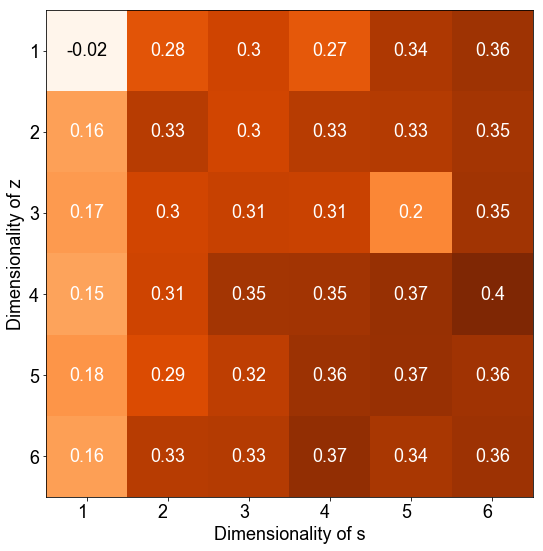

In [24]:
import matplotlib

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

vegetables = [1, 2, 3, 4, 5, 6]
farmers = [1, 2, 3, 4, 5, 6]

harvest = g_scores[0].mean(axis=0)

fig, ax = plt.subplots(figsize=[8, 8])
im = ax.imshow(harvest, cmap='Oranges')

# We want to show all ticks...
ax.set_xticks(np.arange(len(farmers)))
ax.set_yticks(np.arange(len(vegetables)))
# ... and label them with the respective list entries
ax.set_xticklabels(farmers)
ax.set_yticklabels(vegetables)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(vegetables)):
    for j in range(len(farmers)):
        if harvest[i, j]>0:
            text = ax.text(j, i, round(harvest[i, j], 2),
                           ha="center", va="center", color="w")
        else:
            text = ax.text(j, i, round(harvest[i, j], 2),
                           ha="center", va="center", color="k")
            

# ax.set_title("Harvest of local farmers (in tons/year)")
ax.set_xlabel("Dimensionality of s")
ax.set_ylabel("Dimensionality of z")
fig.tight_layout()
plt.show()

# Sensitivity Analysis 5

In [6]:
import os.path

np.random.seed(0)

scales = [0, 0.2, 0.4, 0.6, 0.8, 1]
iters = 5

standard_scores = np.zeros((iters, len(scales)))
contrastive_scores = np.zeros((iters, len(scales)))
b_scores = [np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales)))]
g_scores = [np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales))), np.zeros((iters, len(scales)))]

for s, scale in enumerate(scales):
    for j in range(iters):
        print('Iteration:', j, scale)
        s_fname = 'results5/numerical-s-' + str(j) + '-' + str(s) + '-normalized.npy'
        g1_fname = 'results5/numerical-g1-' + str(j) + '-' + str(s) + '-normalized.npy'
        
        for i in range(target.shape[0]):
            idx = np.random.choice(target_indices) # randomly pick a image 
            loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
            superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
            if i >= int(scale/(scale+1)*target.shape[0]):
                target[i] = foreground[i] + 2*superimposed_patch
            else:
                target[i] = 2*superimposed_patch

            idx = np.random.choice(background_indices) # randomly pick a image 
            loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
            background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])    
            background[i] = background_patch + scale*np.random.random(background_patch.shape)
            
        target = target / target.max()
        background = background / background.max()            

        
        if os.path.isfile(s_fname):
            temp = np.load(s_fname)
            x, y = temp.shape
            standard_scores[:x, :y] = temp 
        else:
            vae, encoder, decoder = standard_vae(input_dim=784, intermediate_dim=32, latent_dim=2)        
            history = vae.fit(target, epochs=50, batch_size=100, validation_data=(target, None), verbose=0)
            ss = plot_latent_space(encoder, target, target_labels, plot=False)
            standard_scores[j, s] = ss
            print(ss)
            np.save(s_fname, standard_scores)
        
        
        for b, (fname, gamma) in enumerate(zip([g1_fname], [1])):
            if os.path.isfile(fname):
                temp = np.load(fname)
                x, y = temp.shape
                g_scores[b][:x, :y] = temp
            else:            
                cvae, cvae_fg, z_encoder, s_encoder, cvae_decoder = contrastive_vae(input_dim=784, intermediate_dim=32, latent_dim=2, disentangle=True, gamma=gamma)
                history = cvae.fit([target, background], epochs=50, batch_size=100, validation_data=([target, background], None), verbose=0)
                ss = plot_latent_space(z_encoder, target, target_labels, plot=False)
                print(ss)
                g_scores[b][j, s] = ss
                np.save(fname, g_scores[b])        

Iteration: 0 0
-0.018
0.335
Iteration: 1 0
-0.018
0.313
Iteration: 2 0
-0.018
0.313
Iteration: 3 0
-0.019
0.282
Iteration: 4 0
-0.017
0.319
Iteration: 0 0.2
-0.018
0.146
Iteration: 1 0.2
-0.016
0.188
Iteration: 2 0.2
-0.015
0.19
Iteration: 3 0.2
-0.017
0.2
Iteration: 4 0.2
-0.016
0.163
Iteration: 0 0.4
-0.015
-0.016
Iteration: 1 0.4
-0.016
0.124
Iteration: 2 0.4
-0.015
0.072
Iteration: 3 0.4
-0.017
0.116
Iteration: 4 0.4
-0.015
0.117
Iteration: 0 0.6
-0.012
-0.015
Iteration: 1 0.6
-0.016
-0.022
Iteration: 2 0.6
-0.016
-0.019
Iteration: 3 0.6
-0.013
0.074
Iteration: 4 0.6
-0.013
0.066
Iteration: 0 0.8
-0.015
-0.002
Iteration: 1 0.8
-0.021
0.018
Iteration: 2 0.8
-0.015
-0.021
Iteration: 3 0.8
-0.011
0.017
Iteration: 4 0.8
-0.015
-0.024
Iteration: 0 1
-0.01
-0.02
Iteration: 1 1
-0.013
-0.005
Iteration: 2 1
-0.013
-0.024
Iteration: 3 1
-0.013
-0.022
Iteration: 4 1
-0.012
-0.024


Text(0, 0.5, 'Silhouette Score')

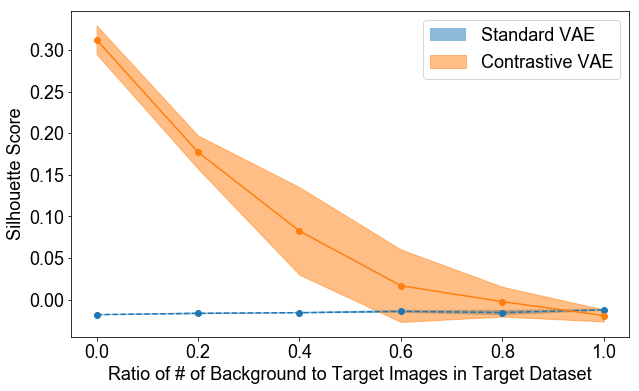

In [22]:
import matplotlib

font = {'family': 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

scales = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])

def plt_shaded(x, y, label=None, c=None, ls='-o'):
    plt.plot(x, y.mean(axis=0), ls, c=c)
    plt.fill_between(x, y.mean(axis=0) - y.std(axis=0), y.mean(axis=0) + y.std(axis=0), alpha=0.5, interpolate=True, label=label, color=c)

plt.figure(figsize=[10,6])
# plt.axhline(-0.009, ls='--', label='Standard VAE')
plt_shaded(scales, standard_scores, ls='--o', label="Standard VAE")
plt_shaded(scales, g_scores[0], label="Contrastive VAE", c='C1')
plt.legend()
plt.xlabel('Ratio of # of Background to Target Images in Target Dataset')
plt.ylabel('Silhouette Score')